In [4]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import numpy as np
from keras.optimizers import Adam

In [5]:
#ツイートのテキスト読み込み
test = open("extract_tweet.txt", "r", encoding="utf-8")
lines = test.readlines()
test.close()
print(len(lines))

#ラベル読み込み
test = open("label.txt", "r", encoding="utf-8")
label = test.readlines()
test.close()
print(len(label))

10000
10000


In [6]:
#userID
test = open("user.txt","r", encoding="utf-8")
uID = test.readlines()
test.close()
print(len(uID))

10000


In [7]:
id_list = []
for i in uID:
    if i in id_list:
        continue
    else:
        id_list.append(i)

In [8]:
print(len(id_list))

32


In [9]:
post_user = []
for i in uID:
    for j in range(len(id_list)):
        if i == id_list[j]:
            post_user.append(j)

In [10]:
n_postUser = np.array(post_user)

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.utils.np_utils import to_categorical

maxlen = 50
training_samples = 8000 # training data 80 : validation data 20
validation_samples = 1000
test_samples = len(lines) - (training_samples + validation_samples)
max_words = 20000

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

# バイナリの行列に変換
categorical_labels = to_categorical(label)
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of label tensor:{}".format(labels.shape))

#学習データとテストデータに分割
x1_test = data[training_samples + validation_samples: training_samples + validation_samples+test_samples]
x2_test = n_postUser[training_samples + validation_samples: training_samples + validation_samples+test_samples]
y_test = labels[training_samples + validation_samples: training_samples + validation_samples+test_samples]
data = data[:training_samples + validation_samples]
labels = labels[:training_samples + validation_samples]
n_postUser = n_postUser[:training_samples + validation_samples]


# 行列をランダムにシャッフルする
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
users = n_postUser[indices]

x1_train = data[:training_samples]
x2_train = users[:training_samples]
y_train = labels[:training_samples]
x1_val = data[training_samples: training_samples + validation_samples]
x2_val = users[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 18881 unique tokens.
Shape of data tensor:(10000, 50)
Shape of label tensor:(10000, 2)


In [12]:
import keras.backend as K
from functools import partial

def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

In [13]:
p_input = Input(shape=(50, ), dtype='int32', name='input_postText')
i_input = Input(shape=(1, ), name='input_ids')

#テキストの学習
em = Embedding(input_dim=20000, output_dim=50, input_length=50)(p_input)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32)(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)
#2つ目のデータ学習
i2 = Dense(32, activation='relu', name = 'dence1')(i_input)
d_i2 = Dropout(0.5)(i2)
x = concatenate([d_lstm_out, d_i2])

m2 = Dense(32, activation='relu', name = 'dence')(x)
d_m2 = Dropout(0.5)(m2)
output = Dense(2, activation='softmax', name = 'output')(d_m2)

optimizer = Adam(lr=1e-3, )
model = Model(inputs=[p_input, i_input], outputs = output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model2.png')


#early_stopping = EarlyStopping(patience=0, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_postText (InputLayer)     (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       1000000     input_postText[0][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 50)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
input_ids (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [14]:
history = model.fit([x1_train, x2_train], y_train,
                    epochs=100, 
                    batch_size=100,
                    validation_data=([x1_val, x2_val], y_val))

Train on 8000 samples, validate on 1000 samples
Epoch 1/100
8000/8000 [==============================] - 8s 975us/step - loss: 1.2220 - acc: 0.4896 - macro_precision: 0.4883 - macro_recall: 0.4882 - macro_f_measure: 0.4882 - val_loss: 0.6964 - val_acc: 0.5280 - val_macro_precision: 0.2640 - val_macro_recall: 0.5000 - val_macro_f_measure: 0.3448
Epoch 2/100
8000/8000 [==============================] - 6s 742us/step - loss: 0.7165 - acc: 0.5442 - macro_precision: 0.5450 - macro_recall: 0.5388 - macro_f_measure: 0.5418 - val_loss: 0.6782 - val_acc: 0.6270 - val_macro_precision: 0.7928 - val_macro_recall: 0.6049 - val_macro_f_measure: 0.6860
Epoch 3/100
8000/8000 [==============================] - 6s 742us/step - loss: 0.6177 - acc: 0.6653 - macro_precision: 0.6767 - macro_recall: 0.6618 - macro_f_measure: 0.6691 - val_loss: 0.5438 - val_acc: 0.7510 - val_macro_precision: 0.7543 - val_macro_recall: 0.7456 - val_macro_f_measure: 0.7499
Epoch 4/100
8000/8000 [==============================] 

8000/8000 [==============================] - 6s 720us/step - loss: 0.0561 - acc: 0.9744 - macro_precision: 0.9743 - macro_recall: 0.9743 - macro_f_measure: 0.9743 - val_loss: 1.5550 - val_acc: 0.7460 - val_macro_precision: 0.7434 - val_macro_recall: 0.7441 - val_macro_f_measure: 0.7437
Epoch 29/100
8000/8000 [==============================] - 6s 783us/step - loss: 0.0601 - acc: 0.9726 - macro_precision: 0.9726 - macro_recall: 0.9725 - macro_f_measure: 0.9725 - val_loss: 1.5065 - val_acc: 0.7490 - val_macro_precision: 0.7472 - val_macro_recall: 0.7461 - val_macro_f_measure: 0.7466
Epoch 30/100
8000/8000 [==============================] - 6s 741us/step - loss: 0.0553 - acc: 0.9726 - macro_precision: 0.9729 - macro_recall: 0.9722 - macro_f_measure: 0.9726 - val_loss: 1.6559 - val_acc: 0.7480 - val_macro_precision: 0.7456 - val_macro_recall: 0.7455 - val_macro_f_measure: 0.7456
Epoch 31/100
8000/8000 [==============================] - 7s 840us/step - loss: 0.0532 - acc: 0.9738 - macro_prec

8000/8000 [==============================] - 6s 781us/step - loss: 0.0483 - acc: 0.9753 - macro_precision: 0.9756 - macro_recall: 0.9749 - macro_f_measure: 0.9752 - val_loss: 2.3523 - val_acc: 0.7470 - val_macro_precision: 0.7452 - val_macro_recall: 0.7445 - val_macro_f_measure: 0.7448
Epoch 56/100
8000/8000 [==============================] - 6s 731us/step - loss: 0.0493 - acc: 0.9766 - macro_precision: 0.9766 - macro_recall: 0.9769 - macro_f_measure: 0.9767 - val_loss: 2.2014 - val_acc: 0.7440 - val_macro_precision: 0.7421 - val_macro_recall: 0.7413 - val_macro_f_measure: 0.7417
Epoch 57/100
8000/8000 [==============================] - 6s 714us/step - loss: 0.0541 - acc: 0.9745 - macro_precision: 0.9747 - macro_recall: 0.9744 - macro_f_measure: 0.9746 - val_loss: 1.9858 - val_acc: 0.7420 - val_macro_precision: 0.7413 - val_macro_recall: 0.7391 - val_macro_f_measure: 0.7402
Epoch 58/100
8000/8000 [==============================] - 6s 730us/step - loss: 0.0487 - acc: 0.9771 - macro_prec

8000/8000 [==============================] - 6s 791us/step - loss: 0.0435 - acc: 0.9770 - macro_precision: 0.9771 - macro_recall: 0.9768 - macro_f_measure: 0.9769 - val_loss: 2.3099 - val_acc: 0.7360 - val_macro_precision: 0.7354 - val_macro_recall: 0.7326 - val_macro_f_measure: 0.7340
Epoch 83/100
8000/8000 [==============================] - 6s 765us/step - loss: 0.0444 - acc: 0.9791 - macro_precision: 0.9795 - macro_recall: 0.9789 - macro_f_measure: 0.9792 - val_loss: 2.3660 - val_acc: 0.7380 - val_macro_precision: 0.7369 - val_macro_recall: 0.7339 - val_macro_f_measure: 0.7354
Epoch 84/100
8000/8000 [==============================] - 6s 779us/step - loss: 0.0435 - acc: 0.9771 - macro_precision: 0.9774 - macro_recall: 0.9768 - macro_f_measure: 0.9771 - val_loss: 2.6013 - val_acc: 0.7410 - val_macro_precision: 0.7391 - val_macro_recall: 0.7387 - val_macro_f_measure: 0.7389
Epoch 85/100
8000/8000 [==============================] - 6s 742us/step - loss: 0.0429 - acc: 0.9776 - macro_prec

In [12]:
loss_and_metrics = model.evaluate([x1_test, x2_test], y_test)
print(loss_and_metrics)

1000/1000 [==============================] - 0s 342us/step
[0.7411905822753906, 0.7, 0.6663632621765136, 0.6150756568908692, 0.6297031216621399]


In [13]:
classes = model.predict([x1_test, x2_test])
np.savetxt('Mult_predict.csv', classes, delimiter = ',')

In [14]:
model.metrics_names

['loss', 'acc', 'macro_precision', 'macro_recall', 'macro_f_measure']

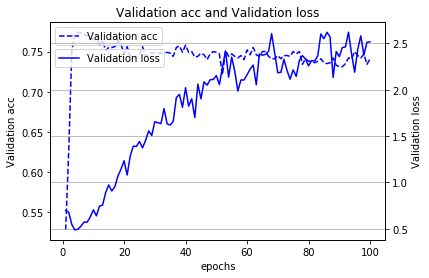

In [16]:
import matplotlib.pyplot as plt

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
epochs = range(1, len(val_acc) + 1)

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')

plt.show()

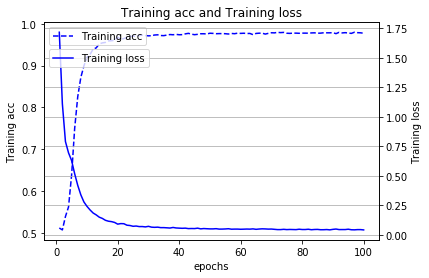

In [16]:
acc = history.history['acc']
loss = history.history['loss']
epochs = range(1, len(val_acc) + 1)

fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, loss, 'b', label='Training loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Training loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Training loss')

plt.show()

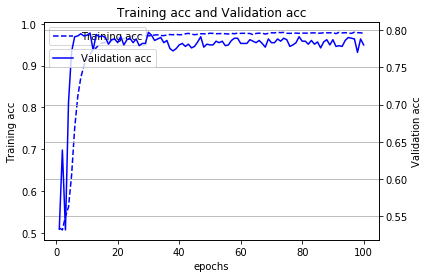

In [17]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, acc, 'b--', label='Training acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_acc, 'b', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Training acc and Validation acc')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Training acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation acc')

plt.show()